# Kernel on Graphs Project
### MVA Master
### Yannis Cattan, Eugène Berta

In [1]:
import cvxopt
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from utils import (
    KernelSVC,
    WL,
    WLK_linear,
    WLK_l2_norm,
    clean_dataset,
    nth_order_walk,
    get_all_atom_types,
    stratified_cross_val,
)

In [2]:
cvxopt.solvers.options['show_progress'] = False

Reading the data:

In [3]:
with open('data/training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

with open('data/test_data.pkl', 'rb') as file:
    test_graphs = pkl.load(file)

with open('data/training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

Cleaning the data:

In [4]:
train_graphs, train_labels = clean_dataset(train_graphs, train_labels)
test_graphs, _ = clean_dataset(test_graphs, np.zeros(2000), discard=False)

Plotting a graph in the dataset:

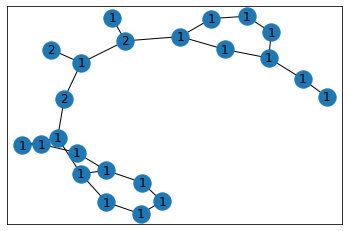

In [5]:
idx=1
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

## Building the Gram Matrix

### Walk kernel Gram Matrix:

In [6]:
# n = 3

# N_train = len(train_graphs)
# indexes_train = np.arange(N_train)

# N_test = len(test_graphs)
# indexes_test = np.arange(N_test)

# G_train = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         g = nth_order_walk(train_graphs[i], train_graphs[j])
#         G_train[i,j] = g
#         G_train[j,i] = g

### Weisfeiler Lehman (WL) Gram Matrix:

Explicit features computation:

In [7]:
max_iter = 2

N_train = len(train_graphs)
indexes_train = np.arange(N_train)

N_test = len(test_graphs)
indexes_test = np.arange(N_test)

X_train = []
for i in indexes_train:
    X_train.append(WL(train_graphs[i], max_iter=max_iter))

X_test = []
for i in indexes_test:
    X_test.append(WL(test_graphs[i], max_iter=max_iter))

#### Linear Kernel:

In [8]:
# G_train_lin = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         g = WLK_linear(X_train[i], X_train[j])
#         G_train_lin[i,j] = g
#         G_train_lin[j,i] = g

In [9]:
# # Matrix normalization:
# Norm = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         n = np.sqrt(G_train_lin[i,i]*G_train_lin[j,j])
#         Norm[i,j] = n
#         Norm[j,i] = n

# G_train_lin = np.divide(G_train_lin, Norm)

In [10]:
# G_test_lin = np.zeros((N_test, N_train))
# for i in tqdm(range(N_test)):
#     for j in range(N_train):
#         G_test_lin[i,j] = WLK_linear(X_test[i], X_train[j]) # / np.sqrt(WLK_linear(X_test[i], X_test[i]) * WLK_linear(X_train[j], X_train[j]))

#### RBF Kernel:

Squared euclidean distance:

In [11]:
G_train_dist = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = WLK_l2_norm(X_train[i], X_train[j])
        G_train_dist[i,j] = g
        G_train_dist[j,i] = g

100%|██████████| 5774/5774 [03:27<00:00, 27.76it/s] 


In [12]:
G_test_dist = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test_dist[i,j] = WLK_l2_norm(X_test[i], X_train[j])

100%|██████████| 2000/2000 [02:44<00:00, 12.18it/s]


RBF Kernel:

In [13]:
# sigma = 4.
# G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
# G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

## SVM with Cross Validation:

Cross validation:

In [14]:
# C = 0.5
# class_weights={-1:1, 1:10}

# models, scores, test_preds = stratified_cross_val(
#     n_fold=5,
#     G_train=G_train_rbf,
#     train_labels=train_labels,
#     G_test=G_test_rbf,
#     C=C,
#     class_weights=class_weights,
#     verbose=True,
#     seed=42
# )
# y_test_pred = np.mean(test_preds, axis=0)

# print(f'\nMean score: {np.mean(scores)}')

## Grid search:

In [16]:
sigmas = [3., 4., 5., 6., 7.]
Cs = [0.2, 0.5, 1., 2.]
class_weights = [{-1:1, 1:1}, {-1:1, 1:5}, {-1:1, 1:10}]

results = []

best_score = 0
y_test_pred = np.zeros(2000)

for sigma in sigmas:
    print(f'#### sigma = {sigma} ####')
    G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
    G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

    for C in Cs:
        for class_weight in class_weights:
            models, scores, test_preds = stratified_cross_val(
                G_train=G_train_rbf,
                train_labels=train_labels,
                G_test=G_test_rbf,
                C=C,
                class_weights=class_weight,
                seed=42,
                verbose=False,
                n_fold=6
            )

            mean_score = np.mean(scores)

            parameters = {
                'h':3,
                'class_weights':class_weight,
                'clean_data':True,
                'sigma':sigma,
                'C':C,
                'mean_score':mean_score
            }

            results.append(parameters)

            if mean_score > best_score:
                best_score = mean_score
                y_test_pred = np.mean(test_preds, axis=0)
                print(f'New best model \n   sigma = {sigma}, C = {C}, class_weights = {class_weight} \n   score = {mean_score}')

dataframe = pd.DataFrame(results)
dataframe.to_csv('grid_search_results.csv')

#### sigma = 3.0 ####
New best model 
   sigma = 3.0, C = 0.2, class_weights = {-1: 1, 1: 1} 
   score = 0.9063710792343783
New best model 
   sigma = 3.0, C = 0.2, class_weights = {-1: 1, 1: 10} 
   score = 0.9072627374999819
New best model 
   sigma = 3.0, C = 0.5, class_weights = {-1: 1, 1: 5} 
   score = 0.9133873811849275
#### sigma = 4.0 ####
New best model 
   sigma = 4.0, C = 0.5, class_weights = {-1: 1, 1: 5} 
   score = 0.9186137460260188
New best model 
   sigma = 4.0, C = 1.0, class_weights = {-1: 1, 1: 5} 
   score = 0.9196477404007369
#### sigma = 5.0 ####
New best model 
   sigma = 5.0, C = 1.0, class_weights = {-1: 1, 1: 5} 
   score = 0.9213921659915272
#### sigma = 6.0 ####
#### sigma = 7.0 ####


In [19]:
df = pd.read_csv('/home/eugene/code/mva-kernel/grid_search_results.csv')
df = df[df['class_weights']=='{-1: 1, 1: 5}']

<AxesSubplot:xlabel='C', ylabel='sigma'>

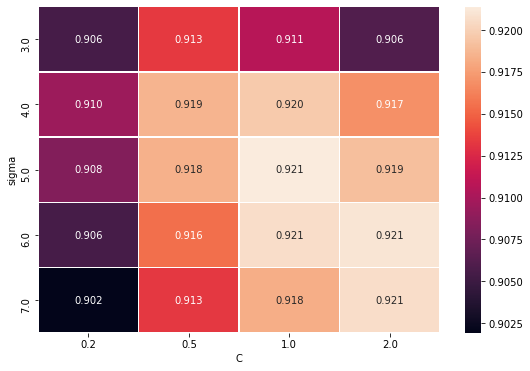

In [20]:
# Load the example flights dataset and convert to long-form
table = df.pivot("sigma", "C", "mean_score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(table, annot=True, fmt='.3f', linewidths=.5, ax=ax)

In [28]:
y_test_pred = np.mean(test_preds, axis=0)

#### Fitting kNN:

In [ ]:
# def kNN(G_val, y_train, k=3):
#     """
#     Given a feature dictionnary whose label is to be predicted, the WL feature vector of the graphs in the training set 
#     and the number of nearest neighbors k, returns the predicted label of G.
#     """
#     neighbours = np.argpartition(G_val, k, axis=1)[:,:k]

#     y_pred = []
#     for i in range(len(neighbours)):
#         is_positive = sum([y_train[i] for i in neighbours[i]])
#         if is_positive > k/2 :
#             y_pred.append(1)
#         else:
#             y_pred.append(0)
#     return np.array(y_pred)

In [ ]:
# y_pred = kNN(G_val, y_train, k=1)

# cm = confusion_matrix(y_val, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
# disp.plot()
# plt.show()

# y_pred.sum()/len(y_pred)

## Submission:

In [25]:
Yte = {'Predicted' : np.array(y_test_pred, dtype=np.float32)}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('test_pred.csv', index_label='Id')